In [1]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
from itertools import combinations

In [2]:
ratings_1 = "combined_data_1.txt"
ratings_2 = "combined_data_2.txt"
ratings_3 = "combined_data_3.txt"
ratings_4 = "combined_data_4.txt"

# Not loading all the data at once to reduce iteration time
# ratings = [ratings_1, ratings_2, ratings_3, ratings_4]
ratings = [ratings_1]
movie_titles = "movie_titles.csv"
dataset_path = "./data"


### Load and preprocess movies and ratings data


The ratings txt file is structured as follows:
moveid id, colon

> 1:

then the ratings for that movie in the format:
customer_id rating date

> 1488844 3 2005-09-06


as such, we need to process a little more manually than pd.read_csv

In [3]:
def load_ratings_data(filename):
    data = []
    with open(filename, 'r') as file:
        current_movie_id = None
        for line in file:
            line = line.strip()
            if line.endswith(':'):
                current_movie_id = int(line.replace(':', ''))
            else:
                customer_id, rating, date = line.split(',')
                data.append([current_movie_id, int(customer_id), float(rating), date])
    return pd.DataFrame(data, columns=['Movie_Id', 'Cust_Id', 'Rating', 'Date'])


In [4]:
df_ratings = pd.concat([load_ratings_data(f"{dataset_path}/{rating}") for rating in ratings])


In [5]:
df_ratings.head(3)

,Movie_Id,Cust_Id,Rating,Date
0,1,1488844,3.0,2005-09-06
1,1,822109,5.0,2005-05-13
2,1,885013,4.0,2005-10-19


In [6]:
print(df_ratings.shape)

(24053764, 4)


In [7]:
df_ratings.describe()

,Movie_Id,Cust_Id,Rating
count,2.405376e+07,2.405376e+07,2.405376e+07
mean,2.308324e+03,1.322285e+06,3.599634e+00
std,1.303909e+03,7.645779e+05,1.086118e+00
min,1.000000e+00,6.000000e+00,1.000000e+00
25%,1.180000e+03,6.609270e+05,3.000000e+00
50%,2.342000e+03,1.318602e+06,4.000000e+00
75%,3.433000e+03,1.984358e+06,4.000000e+00
max,4.499000e+03,2.649429e+06,5.000000e+00


Total number of unique customers: 470758


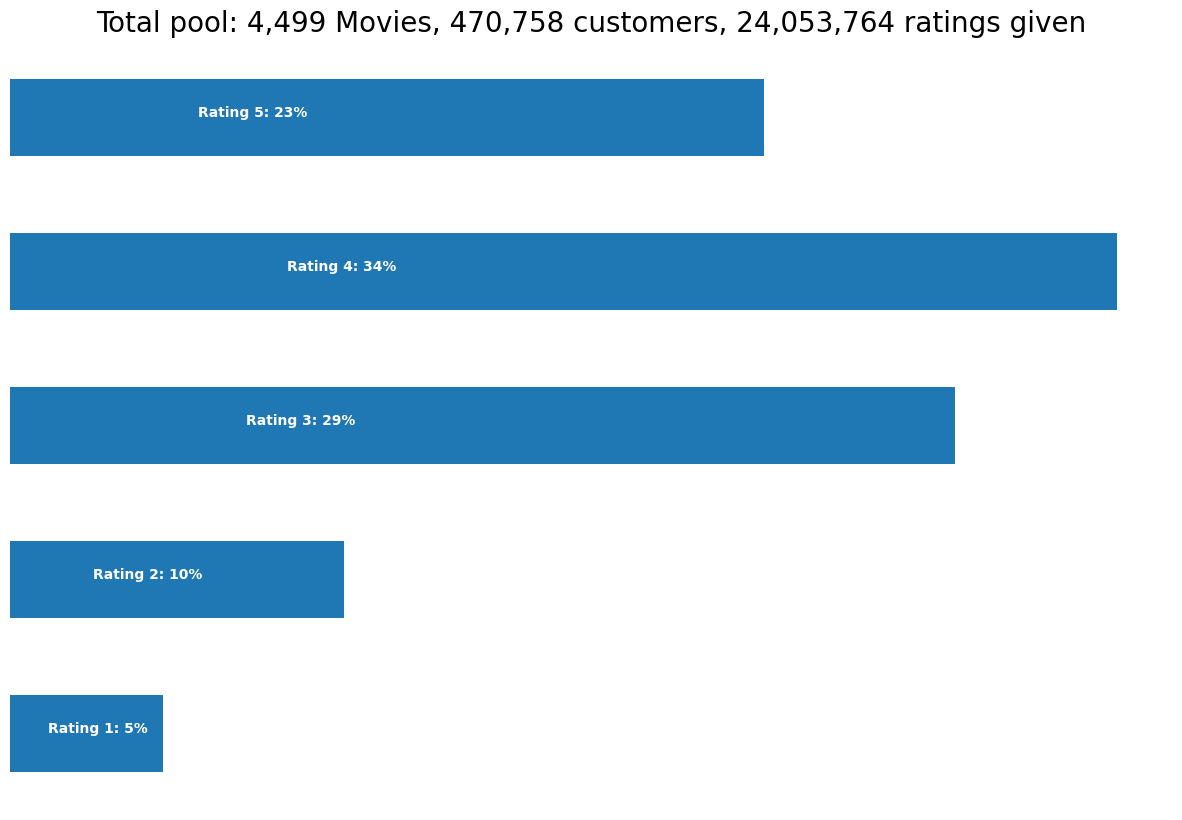

In [8]:
cust_count = df_ratings['Cust_Id'].nunique()
movie_count = df_ratings['Movie_Id'].nunique()
rating_count = df_ratings['Cust_Id'].count()


print(f"Total number of unique customers: {cust_count}")

p = df_ratings.groupby('Rating')['Rating'].agg(['count'])

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

In [9]:
titles = []

with open(f"{dataset_path}/{movie_titles}", encoding="ISO-8859-1") as file:
    reader = csv.reader(file)
    for row in reader:
        movie_id = int(row[0])
        # Need to handle a few cases where the year is missing. 
        if row[1] == 'NULL':
            year = -1
        else:
            year = int(row[1])
        # Need to handle the case where a movie title has a comman in the name
        name = ','.join(row[2:]) 
        titles.append([movie_id, year, name])

df_titles = pd.DataFrame(titles, columns=['Movie_Id', 'Movie_Year', 'Name'])
df_titles.set_index('Movie_Id', inplace=True)


In [10]:
df_titles.head(3)

,Movie_Year,Name
Movie_Id,,
1,2003,Dinosaur Planet
2,2004,Isle of Man TT 2004 Review
3,1997,Character


In [11]:
df = df_ratings.join(df_titles, on='Movie_Id', how='inner')

In [12]:
df.head()

,Movie_Id,Cust_Id,Rating,Date,Movie_Year,Name
0,1,1488844,3.0,2005-09-06,2003,Dinosaur Planet
1,1,822109,5.0,2005-05-13,2003,Dinosaur Planet
2,1,885013,4.0,2005-10-19,2003,Dinosaur Planet
3,1,30878,4.0,2005-12-26,2003,Dinosaur Planet
4,1,823519,3.0,2004-05-03,2003,Dinosaur Planet


In [13]:
# No missing values

# na_check = df.isna().sum()
# print(na_check)

### Enrich data with average rating and review count for each movie

In [14]:
average_ratings = df.groupby('Movie_Id')['Rating'].mean().reset_index()
average_ratings.columns = ['Movie_Id', 'Average_Rating']

review_counts = df.groupby('Movie_Id')['Rating'].count().reset_index()
review_counts.columns = ['Movie_Id', 'Review_Count']

In [15]:
df = df.merge(average_ratings, on='Movie_Id', how='inner')
df = df.merge(review_counts, on='Movie_Id', how='inner')

### Find set of N movies where the customers have rate all N movies 

In [16]:
KEEP_TOP_N = 20
top_movies = review_counts.sort_values(by='Review_Count', ascending=False)['Movie_Id']
top_n_movies = top_movies.head(KEEP_TOP_N)

In [17]:
df_top_n = df[df['Movie_Id'].isin(top_n_movies)]
print(df_top_n.shape)

(2899956, 8)


In [18]:
pivot_table = df_top_n.pivot_table(index='Cust_Id', columns='Movie_Id', values='Rating', aggfunc='count', fill_value=0)


In [19]:
customers_all_n_movies = pivot_table[pivot_table.sum(axis=1) == KEEP_TOP_N].index


In [20]:
df_final = df_top_n[df_top_n['Cust_Id'].isin(customers_all_n_movies)]


In [21]:
df_final.head()

,Movie_Id,Cust_Id,Rating,Date,Movie_Year,Name,Average_Rating,Review_Count
3013412,571,1844276,5.0,2002-03-05,1999,American Beauty,3.962585,154832
3013441,571,2422606,1.0,2001-11-20,1999,American Beauty,3.962585,154832
3013461,571,1515501,3.0,2002-11-25,1999,American Beauty,3.962585,154832
3013465,571,181323,4.0,2002-01-22,1999,American Beauty,3.962585,154832
3013495,571,243963,4.0,2002-02-26,1999,American Beauty,3.962585,154832


In [22]:
print(df_final.shape)

(89620, 8)


In [23]:
print(f"Number of customers who reviewed all {KEEP_TOP_N} movies: {len(customers_all_n_movies)}")
print(df_titles.loc[top_n_movies])


Number of customers who reviewed all 20 movies: 4481
          Movie_Year                                               Name
Movie_Id                                                               
1905            2003  Pirates of the Caribbean: The Curse of the Bla...
2152            2000                                    What Women Want
3860            2003                                     Bruce Almighty
4432            2003                                    The Italian Job
571             1999                                    American Beauty
3938            2004                                            Shrek 2
4306            1999                                    The Sixth Sense
2452            2001      Lord of the Rings: The Fellowship of the Ring
1962            2004                                     50 First Dates
3962            2003                          Finding Nemo (Widescreen)
1145            2001                                The Wedding Planner
3624       

In [26]:
df_final.shape

(89620, 8)

### Save Dataframes

In [24]:
df_final.to_csv(f"{dataset_path}/df_top_20_movies_customers_reviewed_all.csv", index=False)

In [80]:
df.to_csv(f"{dataset_path}/df_all_enriched.csv", index=False)